<a href="https://colab.research.google.com/github/arthursl12/POC1/blob/main/POC2_FD004_MLP_optim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
%pip install scikeras;
%pip install -U tensorflow-addons;
%pip install scikit-optimize

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import datetime

H:\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
H:\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
H:\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import GroupKFold

from sklearn.base import BaseEstimator,RegressorMixin

In [4]:
from skopt import BayesSearchCV

from skopt.space.space import Categorical, Integer, Real

In [5]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Masking

from tensorflow.keras.metrics import RootMeanSquaredError as RMSE

from keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import tensorflow_addons as tfa
from tensorflow_addons.metrics import RSquare as R2

from scikeras.wrappers import KerasRegressor

In [6]:
sns.set_palette('colorblind')

In [7]:
# Reproducibility
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [8]:
tf.config.experimental.enable_op_determinism()

In [9]:
# Remove some tf warnings
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# Data Preparation

In [10]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    IN_COLAB = True
    folder="/content/CMaps/"

    # Dataset Download 
    os.system('git clone https://github.com/arthursl12/dataset_2')
    os.system('mv /content/dataset_2/CMaps /content/CMaps')
    os.system('mv /content/dataset_2/data_processing /content/data_processing')
    os.system('rm -rf dataset_2')
else:
    print('Not running on CoLab')
    IN_COLAB = False
    folder="CMaps/"
    %cd dataset_2/

Not running on CoLab
C:\Users\Arthur Lima\POC\dataset_2


In [11]:
from data_processing.processing import DatasetProcessing
from data_processing.training import HyperparameterSearch, reclipper_scorer
from data_processing.eval import Evaluation

In [12]:
proc = DatasetProcessing()

## Data Integration

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:  

1) unit number   
2) time, in cycles  
3) operational setting 1  
4) operational setting 2  
5) operational setting 3    
6) sensor measurement 1    
7) sensor measurement 2  
...  
26) sensor measurement 20


There are 6 conditions (or combinations) which the 3 operational settings can take.  
Condition 1: Altitude = 0, Mach Number = 0, TRA = 100  
Condition 2: Altitude = 10, Mach Number = 0.25, TRA = 100  
Condition 3: Altitude = 20, Mach Number = 0.7 TRA = 100  
Condition 4: Altitude = 25, Mach Number = 0.62, TRA = 60  
Condition 5: Altitude = 35 Mach Number = 0.84, TRA = 100  
Condition 6: Altitude = 42, Mach Number = 0.84, TRA = 100  
  
There is slight variation in all these conditions so you may get numbers like 24.453 instead of 25 exactly.

FD001: Condition 1 only  
FD002: Mix of all the conditions  
FD003: Condition 1 only  
FD004: Mix of all conditions  


In [13]:
index_cols, settings_cols, sensors_cols, cols = proc.column_names()
train, test, y_test = proc.read_dataset(4,folder=folder)
train

,unit_number,time,op_1,op_2,op_3,s_0,s_1,s_2,s_3,s_4,...,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20
0,1,1,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,249,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,...,380.16,2388.73,8185.69,8.4541,0.03,372,2319,100.00,29.11,17.5234
61245,249,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,...,535.02,2388.46,8185.47,8.2221,0.03,396,2388,100.00,39.38,23.7151
61246,249,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,...,535.41,2388.48,8193.94,8.2525,0.03,395,2388,100.00,39.78,23.8270
61247,249,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,...,187.92,2388.83,8125.64,9.0515,0.02,337,2223,100.00,15.26,9.0774


## Preprocessing

### Test Set Transformation 
Test set has samples for all cycles, but has annotations only for last one

In [14]:
test.shape, y_test.shape

((41214, 26), (248, 1))

In [15]:
test_last = proc.transform_test_keep_setting(test)
test_last.head()

,op_1,op_2,op_3,s_0,s_1,s_2,s_3,s_4,s_5,s_6,...,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20
0,25.0070,0.6214,60.0,462.54,537.66,1264.31,1046.41,7.05,8.99,176.56,...,166.19,2028.53,7890.31,10.7615,0.02,308,1915,84.93,14.41,8.6329
1,41.9989,0.8400,100.0,445.00,549.96,1354.05,1133.55,3.91,5.72,139.03,...,130.17,2387.72,8073.44,9.3925,0.02,331,2212,100.00,10.58,6.4325
2,42.0005,0.8401,100.0,445.00,549.47,1341.06,1118.90,3.91,5.69,139.26,...,130.73,2388.18,8095.58,9.2974,0.02,330,2212,100.00,10.61,6.3488
3,25.0018,0.6207,60.0,462.54,536.06,1253.49,1038.53,7.05,9.00,175.63,...,164.91,2028.30,7878.63,10.8396,0.02,306,1915,84.93,14.41,8.5696
4,25.0039,0.6200,60.0,462.54,537.36,1263.60,1052.52,7.05,9.03,175.53,...,164.95,2028.24,7873.75,10.9094,0.02,307,1915,84.93,14.19,8.6248


In [16]:
X_test = test_last

### Remaining Useful Life (RUL)

In [17]:
train = proc.add_remaining_useful_life_linear(train)
train[index_cols+['RUL']].head()

,unit_number,time,RUL
0,1,1,320
1,1,2,319
2,1,3,318
3,1,4,317
4,1,5,316


## Attributes and target separation

In [18]:
X_train, y_train = proc.X_y_train_divide_with_settings(train)

In [19]:
y_train.head()

,RUL
0,320
1,319
2,318
3,317
4,316


In [20]:
X_train.head()

,op_1,op_2,op_3,s_0,s_1,s_2,s_3,s_4,s_5,s_6,...,s_11,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20
0,42.0049,0.8400,100.0,445.00,549.68,1343.43,1112.93,3.91,5.70,137.36,...,129.78,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670
1,20.0020,0.7002,100.0,491.19,606.07,1477.61,1237.50,9.35,13.61,332.10,...,312.59,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552
2,42.0038,0.8409,100.0,445.00,548.95,1343.12,1117.05,3.91,5.69,138.18,...,129.62,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213
3,42.0000,0.8400,100.0,445.00,548.70,1341.24,1118.03,3.91,5.70,137.98,...,129.80,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176
4,25.0063,0.6207,60.0,462.54,536.10,1255.23,1033.59,7.05,9.00,174.82,...,164.11,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754


## Training and Evaluation functions

In [21]:
eval = Evaluation()

In [22]:
search = HyperparameterSearch()

# MLP Construction

## Callbacks

In [23]:
# Early Stopping Callback
es = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                      patience=5, restore_best_weights=True)

In [24]:
# Printing Callback
def printLog(epoch, logs):
    print(
        f"E {epoch+1}\t: loss={logs['loss']:.3f}, "+
        f"rmse={logs['root_mean_squared_error']:.3f}, "+
        f"r2={logs['r_square']:.3f}; "+
        f"v_loss={logs['val_loss']:.3f}, "+
        f"v_rmse={logs['val_root_mean_squared_error']:.3f}, "+
        f"v_r2={logs['val_r_square']:.3f}; "
    )

printerCallback = LambdaCallback(on_epoch_end=printLog)

## Constants

In [25]:
# X_train must include indices
train3 = train.copy()
X_train_ = train3.drop(columns=[index_cols[1]]+["RUL"])

In [26]:
INPUT_SHAPE = 0

## Wrapper

In [27]:
from sys import is_finalizing
from sklearn.metrics import r2_score

class MLPWrapperRegressor(BaseEstimator,RegressorMixin):
    def __init__(self, basemodel=None, clip_y=-1,
                 include_settings=False, poly_degree=1,
                 scaler=StandardScaler()):
        # Base parameters
        self.basemodel = basemodel
        self.clip_y = clip_y
        self.poly_degree = poly_degree
        self.include_settings = include_settings

        # Column indexers
        self.feature_cols = sensors_cols
        if(include_settings):
            self.feature_cols = settings_cols + self.feature_cols
        self.base_feature_cols = self.feature_cols

        # Scaler and PolyFeatures transformers
        self.scaler = scaler
        self.polyft = PolynomialFeatures(degree=self.poly_degree, 
                                         include_bias=False)

    def clean_cols(self,df):
        if("unit_number" in df.columns): del df["unit_number"]
        if("unit_number" in df.columns): del df["unit_number"]
        if("time" in df.columns): del df["time"]
        if((not self.include_settings)): 
            for col in settings_cols:
                if(col in df.columns): del df[col]
        return df

    def fit(self, X=None, y=None):
        # Drop irrelevant column
        data = pd.DataFrame(X).copy()
        data = self.clean_cols(data)
        
        # Apply polynomial features and add them to the dataframe
        transf = self.polyft.fit_transform(data)
        data = pd.DataFrame(transf, columns=
                              self.polyft.get_feature_names_out())
        self.feature_cols = list(self.polyft.get_feature_names_out())

        # Scale the data
        data = self.scaler.fit_transform(data)
        data = pd.DataFrame(data, 
                            columns=self.scaler.get_feature_names_out())
        X_train = data.copy()
        
        # Clip and transform labels
        data2 = pd.DataFrame(y, columns=["RUL"]).copy()
        if (self.clip_y > 0):
            data2["RUL"].clip(upper=self.clip_y, inplace=True)
        y_train = data2

        # Update input shape for future use
        global INPUT_SHAPE
        INPUT_SHAPE = X_train.shape[1]

        # Fit model
        self.basemodel.fit(X_train,y_train)
        return self
        
    def predict(self, X=None):
        # Perform transformation, if not done
        if (len(X.columns) != len(self.feature_cols)):
            X_train = self.transform_features(X)
        else:
            X_train = X
        return self.basemodel.predict(X_train)

    def transform_features(self, df):
        # Drop irrelevant column
        data = pd.DataFrame(df).copy()
        data = self.clean_cols(data)
        
        # Apply polynomial features and add them to the dataframe
        transf = self.polyft.transform(data)
        data = pd.DataFrame(transf, columns=
                              self.polyft.get_feature_names_out())
        # self.feature_cols = list(self.polyft.get_feature_names_out())

        # Scale the data
        data = self.scaler.transform(data)
        data = pd.DataFrame(data, 
                            columns=self.scaler.get_feature_names_out())
        return data

    def score(self, X, y, sample_weight=None):
        X_test = self.transform_features(X)

        # Clip and transform labels
        data2 = pd.DataFrame(y, columns=["RUL"]).copy()
        if (self.clip_y > 0):
            data2["RUL"].clip(upper=self.clip_y, inplace=True)
        y_test = data2

        # Predict on test data
        y_pred = self.predict(X_test)
        return r2_score(y_test, y_pred, sample_weight=sample_weight)

## Test Data

In [28]:
def scale_test(test,model):
    test2 = pd.DataFrame(test)
    test2 = model.clean_cols(test2)

    # Apply polynomial features
    transf = model.polyft.transform(test2)
    test2 = pd.DataFrame(transf, 
                         columns=model.polyft.get_feature_names_out())

    # Scale the data (with train data parameters)
    test2 = model.scaler.transform(test2)
    test2 = pd.DataFrame(test2, 
                         columns=model.polyft.get_feature_names_out())
    return test2

## Constructor

In [29]:
def create_model(optim=Adam, learning_rate=1e-3, 
                 layer1=32  , activation1="tanh"    , dropout1=0.1,
                 layer2=None, activation2="tanh"    , dropout2=0.1,
                 layer3=None, activation3="tanh"    , dropout3=0.1,
                 layer4=None, activation4="tanh"    , dropout4=0.1,
                 print_summary=False, loss='mean_squared_error',
                 metrics=[tf.keras.metrics.MeanSquaredError()]):
    model = Sequential()

    # Fully Connected Layer
    model.add(Dense(layer1, input_dim=INPUT_SHAPE, activation=activation1))
    model.add(Dropout(dropout1))

    # Additional hidden layers
    if(layer2 is not None):
        model.add(Dense(layer2, activation=activation2))
        model.add(Dropout(dropout2))
        if (layer3 is not None):
            model.add(Dense(layer3, activation=activation3))
            model.add(Dropout(dropout3))
            if (layer4 is not None):
                model.add(Dense(layer4, activation=activation4))
                model.add(Dropout(dropout4))

    # Output Layer
    model.add(Dense(1))

    model.compile(loss=loss, optimizer=optim(learning_rate=learning_rate), 
                  metrics=metrics)
    
    if(print_summary): model.summary()
    return model

# HyperParameter Tuning

In [35]:
CLIP=126

model = MLPWrapperRegressor(
        clip_y=CLIP,scaler=MinMaxScaler(),
        include_settings=True,
        basemodel=
            KerasRegressor(model=create_model,
                           batch_size=64,
                           epochs=1,
                           validation_split=0.2, 
                           model__layer1=512, 
                           model__activation1='relu',
                           model__dropout1=0.5, 
                           model__layer2=64,
                           model__layer3=64,
                           model__layer4=64,
                           model__learning_rate=0.01,
                           model__optim=Adam,
                        #    verbose=0, callbacks=[es,printerCallback],
                           verbose=0, callbacks=[es],
                           model__metrics=[RMSE(), R2()],
                           model__loss='mse',
                           print_summary=False
                           )
    )

In [36]:
# ~3h (LSTM)
# ~45min (MLP)
GRID_SEARCH = True
if (GRID_SEARCH):
    param_distributions = {
        "include_settings": Categorical([True]),
        "clip_y": Integer(80,140),
        "poly_degree": Categorical([2,3]),
        "scaler": Categorical([MinMaxScaler(),StandardScaler()]),
        "basemodel__epochs": Integer(1,50),
        "basemodel__validation_split":Real(0.1,0.9),
        "basemodel__batch_size": Integer(32,512),
        "basemodel__model__optim":Categorical([Adam,RMSprop]),
        "basemodel__model__learning_rate": Real(1e-4, 1e-2),
        
        "basemodel__model__layer1": Integer(16,512),
        "basemodel__model__activation1": Categorical(["relu","elu","selu","tanh", "sigmoid"]),
        "basemodel__model__dropout1": Real(0.1,0.9),

        "basemodel__model__layer2": Integer(16,512),
        "basemodel__model__activation2": Categorical(["relu","elu","selu","tanh", "sigmoid"]),
        "basemodel__model__dropout2": Real(0.1,0.9),

        "basemodel__model__layer3": Integer(16,512),
        "basemodel__model__activation3": Categorical(["relu","elu","selu","tanh", "sigmoid"]),
        "basemodel__model__dropout3": Real(0.1,0.9),

        "basemodel__model__layer4": Integer(16,512),
        "basemodel__model__activation4": Categorical(["relu","elu","selu","tanh", "sigmoid"]),
        "basemodel__model__dropout4": Real(0.1,0.9),
    }
    gcv = GroupKFold(n_splits=3)
    groups=X_train_['unit_number']
    bss = BayesSearchCV(model, param_distributions, 
                        verbose=3, n_jobs=1, refit=False,
                        cv=gcv.split(X_train_, groups=groups), n_iter=45)
    model = bss.fit(X_train_, y_train)
    
    # print(bss.best_estimator_)
    print("Finished:", datetime.datetime.now())

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END basemodel__batch_size=395, basemodel__epochs=35, basemodel__model__activation1=relu, basemodel__model__activation2=relu, basemodel__model__activation3=relu, basemodel__model__activation4=relu, basemodel__model__dropout1=0.10943439441683457, basemodel__model__dropout2=0.36767153029821664, basemodel__model__dropout3=0.751142950611607, basemodel__model__dropout4=0.8839080434806221, basemodel__model__layer1=89, basemodel__model__layer2=27, basemodel__model__layer3=459, basemodel__model__layer4=268, basemodel__model__learning_rate=0.004718825042443329, basemodel__model__optim=<class 'keras.optimizer_v2.rmsprop.RMSprop'>, basemodel__validation_split=0.35084731166926875, clip_y=119, include_settings=True, poly_degree=2, scaler=StandardScaler();, score=0.075 total time=  25.2s
[CV 2/3] END basemodel__batch_size=395, basemodel__epochs=35, basemodel__model__activation1=relu, basemodel__model__activation2=relu, basemodel__mod

In [37]:
# print(bss.best_estimator_)
print(bss.best_score_)
print(bss.best_params_)
print("Finished:", datetime.datetime.now())

0.7547335898188002
OrderedDict([('basemodel__batch_size', 33), ('basemodel__epochs', 35), ('basemodel__model__activation1', 'tanh'), ('basemodel__model__activation2', 'selu'), ('basemodel__model__activation3', 'selu'), ('basemodel__model__activation4', 'selu'), ('basemodel__model__dropout1', 0.35902813826517177), ('basemodel__model__dropout2', 0.10018359566403763), ('basemodel__model__dropout3', 0.3129879941596555), ('basemodel__model__dropout4', 0.3715931098343138), ('basemodel__model__layer1', 24), ('basemodel__model__layer2', 209), ('basemodel__model__layer3', 95), ('basemodel__model__layer4', 512), ('basemodel__model__learning_rate', 0.00029766030712635185), ('basemodel__model__optim', <class 'keras.optimizer_v2.adam.Adam'>), ('basemodel__validation_split', 0.5105596671166837), ('clip_y', 127), ('include_settings', True), ('poly_degree', 2), ('scaler', StandardScaler())])
Finished: 2022-10-27 10:15:56.170894


Finished: 2022-10-27 10:15:56.201919


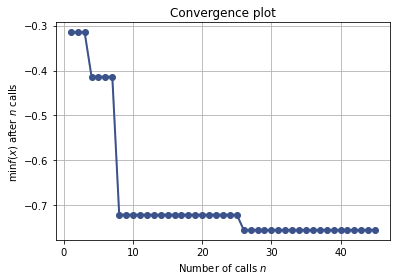

In [38]:
from skopt.plots import plot_convergence

plot_convergence(bss.optimizer_results_)
print("Finished:", datetime.datetime.now())

In [39]:
bss.best_params_

OrderedDict([('basemodel__batch_size', 33),
             ('basemodel__epochs', 35),
             ('basemodel__model__activation1', 'tanh'),
             ('basemodel__model__activation2', 'selu'),
             ('basemodel__model__activation3', 'selu'),
             ('basemodel__model__activation4', 'selu'),
             ('basemodel__model__dropout1', 0.35902813826517177),
             ('basemodel__model__dropout2', 0.10018359566403763),
             ('basemodel__model__dropout3', 0.3129879941596555),
             ('basemodel__model__dropout4', 0.3715931098343138),
             ('basemodel__model__layer1', 24),
             ('basemodel__model__layer2', 209),
             ('basemodel__model__layer3', 95),
             ('basemodel__model__layer4', 512),
             ('basemodel__model__learning_rate', 0.00029766030712635185),
             ('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
             ('basemodel__validation_split', 0.5105596671166837),
             ('clip_y', 127)

# MLP 1-layer 



## Linear RUL

Score: 0.540842574601971  
Test: 0.
```
('basemodel__batch_size', 275),
             ('basemodel__epochs', 37),
             ('basemodel__model__activation1', 'relu'),
             ('basemodel__model__dropout1', 0.2142001322493293),
             ('basemodel__model__layer1', 512),
             ('basemodel__model__learning_rate', 0.007899917433901438),
             ('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
             ('basemodel__validation_split', 0.1),
             ('include_settings', True),
             ('scaler', StandardScaler())
```







## Non-Linear RUL
Score: 0.8250779110568915  
Test: 0.
```
('basemodel__batch_size', 32),
             ('basemodel__epochs', 49),
             ('basemodel__model__activation1', 'tanh'),
             ('basemodel__model__dropout1', 0.1),
             ('basemodel__model__layer1', 512),
             ('basemodel__model__learning_rate', 0.01),
             ('basemodel__model__optim', keras.optimizer_v2.rmsprop.RMSprop),
             ('basemodel__validation_split', 0.14787301913541884),
             ('clip_y', 80),
             ('include_settings', True),
             ('scaler', StandardScaler())
```



## Linear RUL + Poly
Score: 0.5269773808976338  
Test: 0.
```
('basemodel__batch_size', 315),
             ('basemodel__epochs', 38),
             ('basemodel__model__activation1', 'relu'),
             ('basemodel__model__dropout1', 0.38326321899773097),
             ('basemodel__model__layer1', 350),
             ('basemodel__model__learning_rate', 0.0024970992234534897),
             ('basemodel__model__optim', keras.optimizer_v2.rmsprop.RMSprop),
             ('basemodel__validation_split', 0.23038975772370296),
             ('include_settings', True),
             ('poly_degree', 2),
             ('scaler', StandardScaler())
```



## Non-Linear RUL + Poly
Score: 0.7360051567025246  
Test: 0.
```
('basemodel__batch_size', 318),
             ('basemodel__epochs', 37),
             ('basemodel__model__activation1', 'elu'),
             ('basemodel__model__dropout1', 0.1),
             ('basemodel__model__layer1', 31),
             ('basemodel__model__learning_rate', 0.0064651627718996674),
             ('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
             ('basemodel__validation_split', 0.1),
             ('clip_y', 93),
             ('include_settings', True),
             ('poly_degree', 2),
             ('scaler', StandardScaler())
```

# MLP 2-layer 



## Linear RUL

Score: 0.5434403412387998  
Test: 0.
```
('basemodel__batch_size', 475),
             ('basemodel__epochs', 31),
             ('basemodel__model__activation1', 'selu'),
             ('basemodel__model__activation2', 'sigmoid'),
             ('basemodel__model__dropout1', 0.1551853147879086),
             ('basemodel__model__dropout2', 0.34328552130273915),
             ('basemodel__model__layer1', 115),
             ('basemodel__model__layer2', 512),
             ('basemodel__model__learning_rate', 0.006720220722226725),
             ('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
             ('basemodel__validation_split', 0.29870359291003556),
             ('include_settings', True),
             ('scaler', StandardScaler())
```



## Non-Linear RUL
Score: 0.8092955367135408  
Test: 0.
```
('basemodel__batch_size', 190),
             ('basemodel__epochs', 50),
             ('basemodel__model__activation1', 'elu'),
             ('basemodel__model__activation2', 'elu'),
             ('basemodel__model__dropout1', 0.10508709834130409),
             ('basemodel__model__dropout2', 0.15866472852550143),
             ('basemodel__model__layer1', 130),
             ('basemodel__model__layer2', 512),
             ('basemodel__model__learning_rate', 0.01),
             ('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
             ('basemodel__validation_split', 0.5585747596345988),
             ('clip_y', 80),
             ('include_settings', True),
             ('scaler', StandardScaler())
```



## Linear RUL + Poly
Score: 0.5403727057267015  
Test: 0.
```
('basemodel__batch_size', 123),
             ('basemodel__epochs', 50),
             ('basemodel__model__activation1', 'selu'),
             ('basemodel__model__activation2', 'selu'),
             ('basemodel__model__dropout1', 0.2440452992785985),
             ('basemodel__model__dropout2', 0.7488072091140527),
             ('basemodel__model__layer1', 289),
             ('basemodel__model__layer2', 490),
             ('basemodel__model__learning_rate', 0.0002194806594294514),
             ('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
             ('basemodel__validation_split', 0.2571693518261989),
             ('include_settings', True),
             ('poly_degree', 2),
             ('scaler', StandardScaler())
```



## Non-Linear RUL + Poly
Score: 0.8137440377581179  
Test: 0.
```
('basemodel__batch_size', 330),
             ('basemodel__epochs', 28),
             ('basemodel__model__activation1', 'selu'),
             ('basemodel__model__activation2', 'sigmoid'),
             ('basemodel__model__dropout1', 0.35104184791262427),
             ('basemodel__model__dropout2', 0.13083828310831028),
             ('basemodel__model__layer1', 340),
             ('basemodel__model__layer2', 191),
             ('basemodel__model__learning_rate', 0.009916920939867237),
             ('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
             ('basemodel__validation_split', 0.1),
             ('clip_y', 87),
             ('include_settings', True),
             ('poly_degree', 2),
             ('scaler', StandardScaler())
```

# MLP 3-layer (TODO)



## Linear RUL

Score: 0.5387760282104624    
Test: 0.
```
('basemodel__batch_size', 314),
             ('basemodel__epochs', 28),
             ('basemodel__model__activation1', 'tanh'),
             ('basemodel__model__activation2', 'selu'),
             ('basemodel__model__activation3', 'selu'),
             ('basemodel__model__dropout1', 0.23024902825797536),
             ('basemodel__model__dropout2', 0.27996962001171605),
             ('basemodel__model__dropout3', 0.6837395507589162),
             ('basemodel__model__layer1', 288),
             ('basemodel__model__layer2', 158),
             ('basemodel__model__layer3', 381),
             ('basemodel__model__learning_rate', 0.002110763064656101),
             ('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
             ('basemodel__validation_split', 0.5017895339783691),
             ('include_settings', True),
             ('scaler', MinMaxScaler())
```



## Non-Linear RUL
Score: 0.8191894908542713    
Test: 0.
```
('basemodel__batch_size', 277),
             ('basemodel__epochs', 50),
             ('basemodel__model__activation1', 'tanh'),
             ('basemodel__model__activation2', 'selu'),
             ('basemodel__model__activation3', 'relu'),
             ('basemodel__model__dropout1', 0.15180815010798232),
             ('basemodel__model__dropout2', 0.4099007005621048),
             ('basemodel__model__dropout3', 0.1),
             ('basemodel__model__layer1', 197),
             ('basemodel__model__layer2', 353),
             ('basemodel__model__layer3', 261),
             ('basemodel__model__learning_rate', 0.0041467234962615715),
             ('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
             ('basemodel__validation_split', 0.17508243717937616),
             ('clip_y', 80),
             ('include_settings', True),
             ('scaler', StandardScaler())
```



## Linear RUL + Poly
Score: 0.5434197290446054    
Test: 0.
```
('basemodel__batch_size', 254),
             ('basemodel__epochs', 44),
             ('basemodel__model__activation1', 'relu'),
             ('basemodel__model__activation2', 'selu'),
             ('basemodel__model__activation3', 'elu'),
             ('basemodel__model__dropout1', 0.22005754217690313),
             ('basemodel__model__dropout2', 0.2204345848078386),
             ('basemodel__model__dropout3', 0.6505425209498465),
             ('basemodel__model__layer1', 165),
             ('basemodel__model__layer2', 512),
             ('basemodel__model__layer3', 485),
             ('basemodel__model__learning_rate', 0.0023431044122668105),
             ('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
             ('basemodel__validation_split', 0.1),
             ('include_settings', True),
             ('poly_degree', 3),
             ('scaler', StandardScaler())
```



## Non-Linear RUL + Poly
Score: 0.8120876882657063   
Test: 0.
```
('basemodel__batch_size', 127),
             ('basemodel__epochs', 32),
             ('basemodel__model__activation1', 'tanh'),
             ('basemodel__model__activation2', 'sigmoid'),
             ('basemodel__model__activation3', 'selu'),
             ('basemodel__model__dropout1', 0.3239516474706593),
             ('basemodel__model__dropout2', 0.4398002541265835),
             ('basemodel__model__dropout3', 0.11820142028402897),
             ('basemodel__model__layer1', 300),
             ('basemodel__model__layer2', 387),
             ('basemodel__model__layer3', 97),
             ('basemodel__model__learning_rate', 0.0007470235779685965),
             ('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
             ('basemodel__validation_split', 0.27478903553784617),
             ('clip_y', 88),
             ('include_settings', True),
             ('poly_degree', 2),
             ('scaler', StandardScaler())
```

# MLP 4-layer (TODO)



## Linear RUL

Score: 0.542517835612285    
Test: 0.
```
('basemodel__batch_size', 239),
             ('basemodel__epochs', 44),
             ('basemodel__model__activation1', 'relu'),
             ('basemodel__model__activation2', 'sigmoid'),
             ('basemodel__model__activation3', 'selu'),
             ('basemodel__model__activation4', 'selu'),
             ('basemodel__model__dropout1', 0.27228148001908253),
             ('basemodel__model__dropout2', 0.7227228862335966),
             ('basemodel__model__dropout3', 0.8720098451745675),
             ('basemodel__model__dropout4', 0.23520720034744447),
             ('basemodel__model__layer1', 222),
             ('basemodel__model__layer2', 355),
             ('basemodel__model__layer3', 254),
             ('basemodel__model__layer4', 94),
             ('basemodel__model__learning_rate', 0.006241072056393434),
             ('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
             ('basemodel__validation_split', 0.3776498733118778),
             ('include_settings', True),
             ('scaler', StandardScaler())
```





## Non-Linear RUL
Score: 0.7979100870641017    
Test: 0.
```
('basemodel__batch_size', 125),
             ('basemodel__epochs', 40),
             ('basemodel__model__activation1', 'tanh'),
             ('basemodel__model__activation2', 'tanh'),
             ('basemodel__model__activation3', 'relu'),
             ('basemodel__model__activation4', 'selu'),
             ('basemodel__model__dropout1', 0.4239282276871049),
             ('basemodel__model__dropout2', 0.7682276844296427),
             ('basemodel__model__dropout3', 0.37470248079723845),
             ('basemodel__model__dropout4', 0.5586631760668447),
             ('basemodel__model__layer1', 486),
             ('basemodel__model__layer2', 470),
             ('basemodel__model__layer3', 244),
             ('basemodel__model__layer4', 123),
             ('basemodel__model__learning_rate', 0.0006832900387850664),
             ('basemodel__model__optim', keras.optimizer_v2.rmsprop.RMSprop),
             ('basemodel__validation_split', 0.2233573353320119),
             ('clip_y', 80),
             ('include_settings', True),
             ('scaler', StandardScaler())
```



## Linear RUL + Poly
Score: 0.5298866447847905    
Test: 0.
```
('basemodel__batch_size', 370),
             ('basemodel__epochs', 33),
             ('basemodel__model__activation1', 'elu'),
             ('basemodel__model__activation2', 'sigmoid'),
             ('basemodel__model__activation3', 'sigmoid'),
             ('basemodel__model__activation4', 'elu'),
             ('basemodel__model__dropout1', 0.6870110349714994),
             ('basemodel__model__dropout2', 0.5029302361015952),
             ('basemodel__model__dropout3', 0.5605207131815848),
             ('basemodel__model__dropout4', 0.6403930728651405),
             ('basemodel__model__layer1', 428),
             ('basemodel__model__layer2', 483),
             ('basemodel__model__layer3', 286),
             ('basemodel__model__layer4', 94),
             ('basemodel__model__learning_rate', 0.0032976496820942666),
             ('basemodel__model__optim', keras.optimizer_v2.rmsprop.RMSprop),
             ('basemodel__validation_split', 0.12379763238695841),
             ('include_settings', True),
             ('poly_degree', 3),
             ('scaler', StandardScaler())
```



## Non-Linear RUL + Poly
Score: 0.7547335898188002  
Test: 0.
```
('basemodel__batch_size', 33),
             ('basemodel__epochs', 35),
             ('basemodel__model__activation1', 'tanh'),
             ('basemodel__model__activation2', 'selu'),
             ('basemodel__model__activation3', 'selu'),
             ('basemodel__model__activation4', 'selu'),
             ('basemodel__model__dropout1', 0.35902813826517177),
             ('basemodel__model__dropout2', 0.10018359566403763),
             ('basemodel__model__dropout3', 0.3129879941596555),
             ('basemodel__model__dropout4', 0.3715931098343138),
             ('basemodel__model__layer1', 24),
             ('basemodel__model__layer2', 209),
             ('basemodel__model__layer3', 95),
             ('basemodel__model__layer4', 512),
             ('basemodel__model__learning_rate', 0.00029766030712635185),
             ('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
             ('basemodel__validation_split', 0.5105596671166837),
             ('clip_y', 127),
             ('include_settings', True),
             ('poly_degree', 2),
             ('scaler', StandardScaler())
```

# MLP Tester



```
('basemodel__batch_size', 32),
('basemodel__epochs', 50),
('basemodel__model__activation1', 'tanh'),
('basemodel__model__activation2', 'elu'),
('basemodel__model__dropout1', 0.1),
('basemodel__model__dropout2', 0.2107518503547072),
('basemodel__model__layer1', 168),
('basemodel__model__layer2', 428),
('basemodel__model__learning_rate', 0.01),
('basemodel__model__optim', keras.optimizer_v2.adam.Adam),
('basemodel__validation_split', 0.13631332793413636),
('clip_y', 80),
('scaler', MinMaxScaler())
```



In [ ]:
CLIP=80

model = MLPWrapperRegressor(
        clip_y=CLIP, scaler=MinMaxScaler(),
        basemodel=
            KerasRegressor(model=create_model,
                           batch_size=32,
                           epochs=50,
                           model__activation1='tanh',
                           model__activation2='elu',
                           model__dropout1=0.1,
                           model__dropout2=0.2107518503547072, 
                           model__layer1=168, 
                           model__layer2=428, 
                           model__learning_rate=0.01,
                           model__optim=Adam,
                           validation_split=0.13631332793413636, 
                           verbose=0, callbacks=[es, printerCallback],
                           model__metrics=[RMSE(), R2()],
                           model__loss='mse',
                           print_summary=True
                           )
    )

In [ ]:
model.fit(X_train_, y_train)

Model: "sequential_270"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_810 (Dense)           (None, 168)               3696      
                                                                 
 dropout_540 (Dropout)       (None, 168)               0         
                                                                 
 dense_811 (Dense)           (None, 428)               72332     
                                                                 
 dropout_541 (Dropout)       (None, 428)               0         
                                                                 
 dense_812 (Dense)           (None, 1)                 429       
                                                                 
Total params: 76,457
Trainable params: 76,457
Non-trainable params: 0
_________________________________________________________________
E 1	: loss=172.561, rmse=13.136, r2=0.712; v_los

MLPWrapperRegressor(basemodel=KerasRegressor(batch_size=32, callbacks=[<keras.callbacks.EarlyStopping object at 0x0000017111EAD250>, <keras.callbacks.LambdaCallback object at 0x0000017111EE4C10>], epochs=50, model=<function create_model at 0x0000017111F378B0>, model__activation1='tanh', model__activation2='elu', model__dropout1=0.1, model__dropout2=0.21075185035470...=428, model__learning_rate=0.01, model__loss='mse', model__metrics=[<keras.metrics.RootMeanSquaredError object at 0x00000172AC584D90>, <tensorflow_addons.metrics.r_square.RSquare object at 0x00000172AC584C10>], model__optim=<class 'keras.optimizer_v2.adam.Adam'>, print_summary=True, validation_split=0.13631332793413636, verbose=0),
                    clip_y=80, scaler=MinMaxScaler())

In [ ]:
model.score(X_test, reclipped_y)

NameError: ignored

In [ ]:
# Scaling and formatting test data
test_sc = scale_test(X_test,model)
# test_wr = gen_test_wrapper(test_sc, SEQ_LENGTH)

# Clipping test labels
reclipped_y = y_test.copy()
if (CLIP > 0): reclipped_y=reclipped_y["RUL"].clip(upper=CLIP)

# Evaluation
eval.show_result(reclipped_y, model.basemodel.predict(test_sc))
# eval.show_result(reclipped_y, model.predict(X_test)) ## Doesn't work for LSTM
print("Finished:", datetime.datetime.now())

NotFittedError: ignored